In [8]:
# copyright ############################### #
# This file is part of the Xtrack Package.  #
# Copyright (c) CERN, 2021.                 #
# ######################################### #


import xtrack as xt
import xobjects as xo
import xpart as xp

import ducktrack as dtk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from tqdm import tqdm








beta_rel = 0.037


gamma = 1.0006852036131262



I=5*1e-3
L = 2.33 # m cooler length
r_beam=25*1e-3

mass0=938.27208816*1e6 #ev/c^2

T_perp = 0.01 # <E> [eV] = kb*T
T_l =  0.001 # <E> [eV]
B = 0.01  # T for ELENA
B_ratio=1e-10
Z=1


c=299792458.0

p0c = mass0*beta_rel*gamma #eV/c



length = 30 #m
T = length/(c*beta_rel)
ms_per_turn = 1000*T


beta_x=2.1
beta_y=2.2
emittance=10*1e-6

arc=dtk.LinearTransferMatrix(Q_x=2.36168984503, Q_y=1.38992572490,
                            beta_x_0=beta_x, beta_x_1=beta_x,
                            beta_y_0=beta_y,  beta_y_1=beta_y,
                            alpha_x_0=0,   alpha_x_1=0,
                            alpha_y_0=0,   alpha_y_1=0,
                            disp_x_0=0,disp_x_1=0,
                            disp_y_0=0,    disp_y_1=0,
                            beta_s=1*1e40,
                            Q_s=0,
                            chroma_x=0.0, chroma_y=0
                                           
                 )



In [9]:
num_turns=int(3e6)
num_particles=1
step=1


    

# initialize arrays
x = []
px = []
y = []
py = []
action_x = []
action_y = []
force = []

dtk_cooler = dtk.elements.ElectronCooler(I=I,L=L,r_beam=r_beam,
                                            T_perp=T_perp,T_l=T_l,
                                            B=B,Z=Z,B_ratio=1e-3,
                                            Neutralisation_space_charge=0,Neutralisation_rotation=0)


dtk_particle = dtk.TestParticles(
    
    mass0=mass0,
    p0c=p0c,
    x=20*1e-3,
    px=0,
    y=0,
    py=0,
    delta=0,
    zeta=0)


goal_action=1e-8

# loop over turns
for i in tqdm(range(num_turns)):
    if i % step == 0:
        # append coordinates to arrays
        x.append(dtk_particle.x)
        px.append(dtk_particle.px)
        y.append(dtk_particle.y)
        py.append(dtk_particle.py)
        
        # calculate action in horizontal plane
        action_x_temp = 0.5*(dtk_particle.x**2/beta_x + beta_x*dtk_particle.px**2)
        action_x.append(action_x_temp)
        
        # calculate action in vertical plane
        action_y_temp = 0.5*(dtk_particle.y**2/beta_y + beta_y*dtk_particle.py**2)
        action_y.append(action_y_temp)
        
        if action_x_temp < goal_action:
            print(f"Reached goal action of {goal_action} in {i} turns.")
            break
                
    # track particle through arc and cooler
    arc.track(dtk_particle)
    dtk_cooler.track(dtk_particle)

# convert arrays to numpy arrays
x = np.array(x)
px = np.array(px)
y = np.array(y)
py = np.array(py)
action_x = np.array(action_x)
action_y = np.array(action_y)
force = np.array(force)

amplitude_x=np.sqrt(2*action_x[::-1]*beta_x)

time = np.arange(0, num_turns, step) * ms_per_turn
time = time[:len(amplitude_x)]



        


100%|██████████| 3000000/3000000 [03:56<00:00, 12659.37it/s]


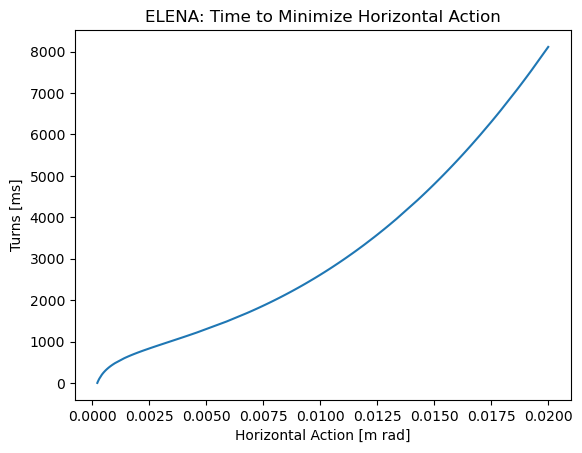

In [10]:
# Plot the horizontal action versus time
plt.figure()
plt.plot(amplitude_x,time)
plt.ylabel('Turns [ms]')
plt.xlabel('Horizontal Action [m rad]')
plt.title('ELENA: Time to Minimize Horizontal Action')
plt.ticklabel_format(useOffset=False)



In [13]:
#np.save("plot_data/amplitude_x_init.npy", amplitude_x)
#np.save("plot_data/time_init.npy", time)

#np.save("plot_data/amplitude_x_sc.npy", amplitude_x)
#np.save("plot_data/time_sc.npy", time)

#np.save("plot_data/amplitude_x_b.npy", amplitude_x)
#np.save("plot_data/time_b.npy", time)


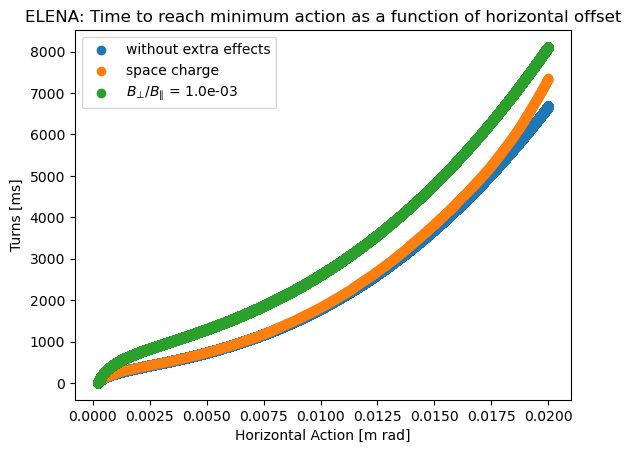

In [16]:
amplitude_x_init=np.load("plot_data/amplitude_x_init.npy")
time_init=np.load("plot_data/time_init.npy")

amplitude_x_sc=np.load("plot_data/amplitude_x_sc.npy")
time_sc=np.load("plot_data/time_sc.npy")

amplitude_x_b=np.load("plot_data/amplitude_x_b.npy")
time_b=np.load("plot_data/time_b.npy")


plt.figure()
plt.scatter(amplitude_x_init,time_init,label='without extra effects')
plt.scatter(amplitude_x_sc,time_sc,label='space charge')
plt.scatter(amplitude_x_b,time_b, label=f"$B_{'⊥'}$/$B_{'∥'}$ = {1e-3:.1e}")
plt.ylabel('Turns [ms]')
plt.xlabel('Horizontal Action [m rad]')
plt.title('ELENA: Time to reach minimum action as a function of horizontal offset')
plt.legend()
plt.show()